In [1]:
import pandas as pd

In [2]:
songs = pd.read_json('../../data/eurovision-lyrics-2022.json') #from https://www.kaggle.com/datasets/minitree/eurovision-song-lyrics?select=eurovision-lyrics-2022.json

In [3]:
# read in the pickle
import pickle
with open('../../data/country_codes_dict.pickle', 'rb') as handle:
    country_codes_dict = pickle.load(handle) 


In [4]:
language = songs.T[['Year','Country','Language']]

# rename the Lnaguage column as Language_sung
language.rename(columns={'Language':'Language_sung'}, inplace=True)

# replace macedonia with f.y.r. macedonia
language['Country'] = language['Country'].replace('Macedonia', 'F.Y.R. Macedonia')

language.head()

,Year,Country,Language_sung
0,1956,Netherlands,Dutch
1,1956,Switzerland,German
2,1956,Belgium,French
3,1956,Germany (West),German
4,1956,France,French


In [5]:
language['Year']= pd.to_numeric(language['Year'])
language = language[language['Year']>1997]

# convert language['Country'] to lower case
language['Country'] = language['Country'].str.lower()

# Add country code column
language['Country_code'] = language['Country'].map(country_codes_dict)

language.head()

,Year,Country,Language_sung,Country_code
772,1998,croatia,Croatian,HR
773,1998,greece,Greek,GR
774,1998,france,French,FR
775,1998,spain,Spanish,ES
776,1998,switzerland,German,CH


In [6]:
# add column to say if English in language as 1, 0 otherwise
language['Language_sung'] = language['Language_sung'].str.lower()

language['Language_sung'] = language['Language_sung'].apply(lambda x: x.replace('title ',' '))
language['Language_sung'] = language['Language_sung'].str.replace('partly', '')
language['Language_sung'] = language['Language_sung'].str.replace('dialect', '')
language['Language_sung'] = language['Language_sung'].str.replace(' and ', ' ')
language['Language_sung'] = language['Language_sung'].str.replace('fr\\.', 'french')
language['Language_sung'] = language['Language_sung'].str.replace('gr\\.', 'greek')
language['Language_sung'] = language['Language_sung'].str.replace('it\\.', 'italian')
language['Language_sung'] = language['Language_sung'].str.replace('sp\\.', 'spanish')
language['Language_sung'] = language['Language_sung'].str.replace('rom\\.', 'romanian')
language['Language_sung'] = language['Language_sung'].str.replace('russ\\.', 'russian')
language['Language_sung'] = language['Language_sung'].str.replace('germ\\.', 'german')
language['Language_sung'] = language['Language_sung'].str.replace('pol\\.', 'polish')
language['Language_sung'] = language['Language_sung'].str.replace('sign language', 'sign-language')

language['Contains_English'] = language['Language_sung'].apply(lambda x: 1 if 'english' in x else 0)

# remove english and white space from language column
language['temp'] = language['Language_sung'].apply(lambda x: x.replace('english',''))
language['temp'] = language['temp'].apply(lambda x: x.strip())
language['temp'] = language['temp'].apply(lambda x: x.replace('(',''))
language['temp'] = language['temp'].apply(lambda x: x.replace(')',''))
language['temp'] = language['temp'].apply(lambda x: x.replace('/',' '))


language['temp'].value_counts()

language['Contains_NonEnglish'] = language['temp'].apply(lambda x: 0 if x=='' else 1)

/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_37632/4175455330.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  language['Language_sung'] = language['Language_sung'].str.replace('fr\\.', 'french')
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_37632/4175455330.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  language['Language_sung'] = language['Language_sung'].str.replace('gr\\.', 'greek')
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_37632/4175455330.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  language['Language_sung'] = language['Language_sung'].str.replace('it\\.', 'italian')
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_37632/4175455330.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  language['Language_sung'] = lan

In [7]:
print('Number of songs containing English or non-English:')

language[['Contains_English', 'Contains_NonEnglish']].value_counts()

Number of songs containing English or non-English:


Contains_English  Contains_NonEnglish
1                 0                      543
0                 1                      220
1                 1                      149
dtype: int64

In [8]:
import pycountry
import requests
from bs4 import BeautifulSoup
import re

In [9]:
# Get the official languages from Wikipedia
url=f"https://en.wikipedia.org/wiki/List_of_official_languages_by_country_and_territory"
response=requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
tables=soup.find_all('table',{'class':"wikitable"})

table = tables[0]

df_table=pd.read_html(str(table))
df_table=pd.DataFrame(df_table[0])

# replace United Kingdom and Crown dependencies etc with United Kingdom
df_table['Country/Region'] = df_table['Country/Region'].replace('United Kingdom and Crown dependencies etc.','United Kingdom')

# Tidy the columns
df_table = df_table.fillna('')
df_table['Country/Region'] = df_table['Country/Region'].apply(lambda x: re.sub("\[.*?\]","",x))
df_table.rename(columns={'Official language':'Official_languages'}, inplace=True)
df_table['Official_languages'] = df_table['Official_languages'].apply(lambda x: re.sub("\[.*?\]","",x))
df_table['Country/Region'] = df_table['Country/Region'].str.lower()
df_table['Country_code'] = df_table['Country/Region'].map(country_codes_dict)
df_table['Official_languages'] = df_table['Official_languages'].str.lower()
df_table['Official_languages'] = df_table['Official_languages'].apply(lambda x: x.replace('all have de facto status',''))
df_table['Official_languages'] = df_table['Official_languages'].apply(lambda x: x.replace(',',''))
df_table['Official_languages'] = df_table['Official_languages'].apply(lambda x: x.replace('(',''))
df_table['Official_languages'] = df_table['Official_languages'].apply(lambda x: x.replace(')',''))

# Add missing languages or country names
df_table = df_table.append({'Country_code':'YU', 'Country/Region':'yugoslavia', 'Official_languages':'serbian montenegrin'}, ignore_index=True)
df_table.loc[df_table['Country_code'] == 'LT', 'Official_languages'] = 'samogitian ' + df_table.loc[df_table['Country_code'] == 'LT', 'Official_languages']
df_table.loc[df_table['Country_code'] == 'FR', 'Official_languages'] = 'breton corsican ' + df_table.loc[df_table['Country_code'] == 'FR', 'Official_languages']
df_table.loc[df_table['Country_code'] == 'SI', 'Official_languages'] = 'slovenian ' + df_table.loc[df_table['Country_code'] == 'SI', 'Official_languages']
df_table.loc[df_table['Country_code'] == 'EE', 'Official_languages'] = 'võro ' + df_table.loc[df_table['Country_code'] == 'EE', 'Official_languages']

df_table.head()

/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_37632/3618544396.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_table = df_table.append({'Country_code':'YU', 'Country/Region':'yugoslavia', 'Official_languages':'serbian montenegrin'}, ignore_index=True)


,Country/Region,Official_languages,Regional language,Minority language,National language,Widely spoken,Country_code
0,abkhazia,abkhaz russian,,Georgian,Abkhaz,,NaN
1,afghanistan,persian dari pashto,Uzbek[b] Turkmen[b] Pashayi[b] Nuristani[b] Ba...,,Persian (Dari) Pashto,Persian (Dari),NaN
2,albania,albanian,,Greek Macedonian Aromanian,,Italian,AL
3,algeria,arabic tamazight,,,Arabic Tamazight,French,NaN
4,andorra,catalan,,Spanish French Portuguese,,,AD


In [10]:
# print langauge['Country'] that are not in df_table['Country/Region']
if len(set(language['Country_code']) - set(df_table['Country_code'])) > 0: 
    print('Countries in language that are not in df_table:')
    print(set(language['Country_code']) - set(df_table['Country_code']))

# merge df_table and language on Country and Country/Region
language = pd.merge(language, df_table[['Country_code', 'Official_languages']], left_on='Country_code', right_on='Country_code', how='left')

In [11]:
# Tidy the languages column
language['temp'] = language['Language_sung'].apply(lambda x: x.replace('/',' '))
language['temp'] = language['temp'].apply(lambda x: x.replace('(',' '))
language['temp'] = language['temp'].apply(lambda x: x.replace(')',' '))
language['temp'] = language['temp'].apply(lambda x: x.replace(',',' '))
language['Official_languages'] = language['Official_languages'].fillna(' ')

language['Contains_Multiple_Languages'] = language['temp'].apply(lambda x: 1 if len(x.split()) > 1 else 0)
language['Number_of_Languages'] = language['temp'].apply(lambda x:len(x.split()))
language['Contains_Own_Language'] = [1 if set(i['temp'].split()).intersection(i['Official_languages'].split()) else 0 for idx,i in language.iterrows()]


language.loc[language['temp'].str.contains('6 other'), 'Number_of_Languages'] = language.loc[language['temp'].str.contains('6 other'), 'Number_of_Languages'] + 4
language.loc[language['temp'].str.contains('10 other'), 'Number_of_Languages'] = language.loc[language['temp'].str.contains('10 other'), 'Number_of_Languages'] + 8
language['temp'] = language['temp'].apply(lambda x: x.replace('6 other',''))
language['temp'] = language['temp'].apply(lambda x: x.replace('10 other',''))

In [12]:
language.loc[language['temp'].str.contains('6 other')]

,Year,Country,Language_sung,Country_code,Contains_English,temp,Contains_NonEnglish,Official_languages,Contains_Multiple_Languages,Number_of_Languages,Contains_Own_Language


In [13]:
# create a list with all words in language['temp']
all_words = []
for i in language['temp']:
    all_words += i.split()

# counts of all elements in all_words
from collections import Counter
counts = Counter(all_words)

# order counts by value
counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

counts = pd.DataFrame(counts, columns=['Language', 'Count'])

counts.head()

,Language,Count
0,english,692
1,french,50
2,spanish,42
3,italian,26
4,hebrew,21


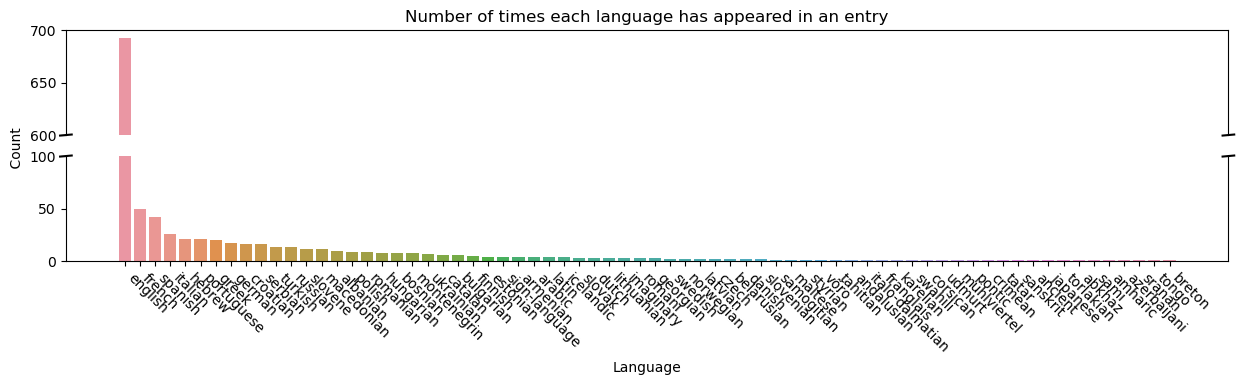

In [14]:
# Bar chart of the top 20 languages

import matplotlib.pyplot as plt
import seaborn as sns


f, (ax, ax2) = plt.subplots(2, 1, figsize=(15,3), sharex=True)


sns.barplot(x='Language', y='Count', data=counts, ax=ax)
sns.barplot(x='Language', y='Count', data=counts, ax=ax2)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(600, 700)  # outliers only
ax2.set_ylim(0, 100)  # most of the data

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

# hide ax xaxis ticks
ax.xaxis.set_visible(False)

#ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .005  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


# hide ax2 x label
ax.set_xlabel('')


# x labels are too long so rotate them
plt.xticks(rotation=-45, ha='left')
ax.set_title('Number of times each language has appeared in an entry')
ax.set_ylabel('')
ax2.set_ylabel('                            Count')

plt.show()


In [15]:
language = language[['Year', 'Country', 'Country_code', 'Official_languages', 'Language_sung',  'Contains_English',
      'Contains_NonEnglish', 'Contains_Own_Language', 'Contains_Multiple_Languages', 'Number_of_Languages' ]]

Who do we have out there that doesn't sing in their own language, or english? 

In [16]:
language.loc[(language['Contains_Own_Language'] == 0) & (language['Contains_English'] == 0)]

,Year,Country,Country_code,Official_languages,Language_sung,Contains_English,Contains_NonEnglish,Contains_Own_Language,Contains_Multiple_Languages,Number_of_Languages
140,2003,belgium,BE,dutch french german,imaginary,0,1,0,0,1
259,2007,cyprus,CY,greek turkish,french,0,1,0,0,1
284,2007,latvia,LV,latvian,italian,0,1,0,0,1
301,2008,estonia,EE,võro estonian,serbian (german/finnish),0,1,0,1,3
304,2008,belgium,BE,dutch french german,imaginary,0,1,0,0,1
362,2009,latvia,LV,latvian,russian,0,1,0,0,1
635,2016,austria,AT,german,french,0,1,0,0,1
716,2018,estonia,EE,võro estonian,italian,0,1,0,0,1


In [17]:
# output to csv
language.to_csv('../../data/performance_languages.csv', index=False)